# DeepFM: Factorization-Machines based Neural Network

This notebook implements **DeepFM** from the paper ["DeepFM: A Factorization-Machine based Neural Network for CTR Prediction"](https://arxiv.org/abs/1703.04247) (Guo et al., 2017) using PyTorch.

## Overview

DeepFM combines two powerful components that share the same input embeddings:

1. **FM (Factorization Machine) Component**: Captures low-order (1st and 2nd order) feature interactions through factorized parameters.

2. **Deep Component**: A deep neural network (MLP) that learns high-order feature interactions from the same embeddings.

### Rich Features in This Implementation

Unlike NeuMF which only uses user_id and item_id, this DeepFM implementation leverages the full MovieLens 100K dataset:

**User Features:**
- `user_id`: Unique user identifier
- `age_bucket`: Age grouped into buckets (7 buckets)
- `gender`: M/F (2 categories)
- `occupation`: 21 different occupations

**Item Features:**
- `item_id`: Unique movie identifier
- `genres`: 19 binary genre indicators (Action, Comedy, Drama, etc.)

### Architecture

```
┌──────────────────────────────────────────────────────────────┐
│                    Sparse Input Features                      │
│  [user_id, age, gender, occupation, item_id, genre1, ..., g19]│
└───────────────────────────┬──────────────────────────────────┘
                            │
              ┌─────────────▼─────────────┐
              │   Shared Embedding Layer  │
              │   (one embedding per field)│
              └─────────────┬─────────────┘
                            │
          ┌─────────────────┴─────────────────┐
          │                                   │
┌─────────▼─────────┐             ┌───────────▼───────────┐
│   FM Component    │             │    Deep Component     │
│  1st + 2nd order  │             │   (MLP layers)        │
│   interactions    │             │   Higher-order        │
└─────────┬─────────┘             └───────────┬───────────┘
          │                                   │
          └─────────────────┬─────────────────┘
                            │
              ┌─────────────▼─────────────┐
              │   Sigmoid(bias + FM + DNN)│
              │   → ŷ (prediction)        │
              └───────────────────────────┘
```

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import time
from collections import defaultdict
from typing import List, Set, Dict, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Reproducibility
SEED = 2025
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## 2. Load MovieLens 100K Dataset with Rich Features

We load three files:
- `u.data`: User-item interactions with ratings and timestamps
- `u.user`: User demographics (age, gender, occupation, zip code)
- `u.item`: Movie information (title, release date, genres)

In [2]:
# Paths
DATA_DIR = "/Users/codexplore/Developer/repos/recommender-system/data/movielens/ml-100k"

# Load interactions
df = pd.read_csv(
    f"{DATA_DIR}/u.data", 
    sep="\t", 
    names=["user", "item", "rating", "timestamp"]
)

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique():,}")
print(f"Unique items: {df['item'].nunique():,}")
df.head()

Total interactions: 100,000
Unique users: 943
Unique items: 1,682


,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# Load user features
df_users = pd.read_csv(
    f"{DATA_DIR}/u.user",
    sep="|",
    names=["user", "age", "gender", "occupation", "zip_code"],
    encoding="latin-1"
)

print(f"User features shape: {df_users.shape}")
print(f"\nAge range: {df_users['age'].min()} - {df_users['age'].max()}")
print(f"Genders: {df_users['gender'].unique().tolist()}")
print(f"Occupations ({df_users['occupation'].nunique()}): {df_users['occupation'].unique().tolist()}")
df_users.head()

User features shape: (943, 5)

Age range: 7 - 73
Genders: ['M', 'F']
Occupations (21): ['technician', 'other', 'writer', 'executive', 'administrator', 'student', 'lawyer', 'educator', 'scientist', 'entertainment', 'programmer', 'librarian', 'homemaker', 'artist', 'engineer', 'marketing', 'none', 'healthcare', 'retired', 'salesman', 'doctor']


,user,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
# Load item features (movies with genres)
genre_names = [
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

item_cols = ["item", "title", "release_date", "video_release", "url"] + genre_names

df_items = pd.read_csv(
    f"{DATA_DIR}/u.item",
    sep="|",
    names=item_cols,
    encoding="latin-1"
)

print(f"Item features shape: {df_items.shape}")
print(f"\nGenre columns: {genre_names}")
print(f"\nExample movie genres:")
df_items[["title"] + genre_names].head()

Item features shape: (1682, 24)

Genre columns: ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Example movie genres:


,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,GoldenEye (1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Get Shorty (1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Copycat (1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## 3. Feature Engineering

We process the features to create categorical indices for DeepFM:

1. **User features**: 
   - Age → bucketed into 7 groups
   - Gender → 2 categories (M=0, F=1)
   - Occupation → 21 categories

2. **Item features**:
   - 19 genre fields, each binary (0 or 1)

In [5]:
# Create age buckets
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = list(range(len(age_bins) - 1))  # 0-6
df_users["age_bucket"] = pd.cut(df_users["age"], bins=age_bins, labels=age_labels, right=False).astype(int)

print("Age bucket distribution:")
print(df_users["age_bucket"].value_counts().sort_index())

Age bucket distribution:
age_bucket
0     36
1    198
2    310
3    194
4    142
5     51
6     12
Name: count, dtype: int64


In [6]:
# Encode categorical features
gender2id = {"M": 0, "F": 1}
df_users["gender_id"] = df_users["gender"].map(gender2id)

occupation2id = {occ: i for i, occ in enumerate(df_users["occupation"].unique())}
df_users["occupation_id"] = df_users["occupation"].map(occupation2id)

print(f"Number of genders: {len(gender2id)}")
print(f"Number of occupations: {len(occupation2id)}")
print(f"\nOccupation mapping: {occupation2id}")

Number of genders: 2
Number of occupations: 21

Occupation mapping: {'technician': 0, 'other': 1, 'writer': 2, 'executive': 3, 'administrator': 4, 'student': 5, 'lawyer': 6, 'educator': 7, 'scientist': 8, 'entertainment': 9, 'programmer': 10, 'librarian': 11, 'homemaker': 12, 'artist': 13, 'engineer': 14, 'marketing': 15, 'none': 16, 'healthcare': 17, 'retired': 18, 'salesman': 19, 'doctor': 20}


In [7]:
# Convert to implicit feedback
df["interaction"] = (df["rating"] >= 4).astype(int)
df_implicit = df[df["interaction"] == 1].copy()

print(f"Positive interactions (rating >= 4): {len(df_implicit):,}")
print(f"Sparsity: {1 - len(df_implicit) / (df['user'].nunique() * df['item'].nunique()):.4%}")

Positive interactions (rating >= 4): 55,375
Sparsity: 96.5088%


In [8]:
# Create 0-based user and item indices
user2id = {u: i for i, u in enumerate(df_implicit["user"].unique())}
item2id = {i: j for j, i in enumerate(df_implicit["item"].unique())}
id2user = {i: u for u, i in user2id.items()}
id2item = {j: i for i, j in item2id.items()}

df_implicit["uid"] = df_implicit["user"].map(user2id)
df_implicit["iid"] = df_implicit["item"].map(item2id)

n_users = len(user2id)
n_items = len(item2id)

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")

Number of users: 942
Number of items: 1447


In [9]:
# Build user feature lookup: uid -> (age_bucket, gender_id, occupation_id)
user_features = {}
for _, row in df_users.iterrows():
    original_user_id = row["user"]
    if original_user_id in user2id:
        uid = user2id[original_user_id]
        user_features[uid] = (
            int(row["age_bucket"]),
            int(row["gender_id"]),
            int(row["occupation_id"])
        )

print(f"User features loaded for {len(user_features)} users")
print(f"Example user 0 features (age_bucket, gender, occupation): {user_features[0]}")

User features loaded for 942 users
Example user 0 features (age_bucket, gender, occupation): (3, 0, 3)


In [10]:
# Build item feature lookup: iid -> [genre1, genre2, ..., genre19]
# Each genre is binary (0 or 1)
item_features = {}
for _, row in df_items.iterrows():
    original_item_id = row["item"]
    if original_item_id in item2id:
        iid = item2id[original_item_id]
        # Get genre values (19 binary features)
        genres = [int(row[g]) for g in genre_names]
        item_features[iid] = genres

print(f"Item features loaded for {len(item_features)} items")
print(f"Example item 0 genres: {item_features[0]}")
print(f"Genre names: {genre_names}")

Item features loaded for 1447 items
Example item 0 genres: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Genre names: ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [11]:
# Define field dimensions for DeepFM
# Each field has its own vocabulary size

n_age_buckets = len(age_labels)  # 7
n_genders = len(gender2id)  # 2
n_occupations = len(occupation2id)  # 21
n_genres = len(genre_names)  # 19 (each is binary: 0 or 1)

# Field dimensions: [user_id, age, gender, occupation, item_id, genre1, genre2, ..., genre19]
# For binary genre fields, dimension is 2 (0 or 1)
field_dims = (
    [n_users, n_age_buckets, n_genders, n_occupations, n_items] + 
    [2] * n_genres  # 19 binary genre fields
)

n_fields = len(field_dims)

print(f"Number of feature fields: {n_fields}")
print(f"Field dimensions: {field_dims}")
print(f"Total feature vocabulary: {sum(field_dims):,}")

Number of feature fields: 24
Field dimensions: [942, 7, 2, 21, 1447, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Total feature vocabulary: 2,457


## 4. Train/Validation/Test Split

We use **temporal leave-one-out** splitting:
- For each user, sort interactions by timestamp
- Last interaction → Test set
- Second-to-last interaction → Validation set  
- All other interactions → Training set

In [12]:
train_data = []
val_data = []
test_data = []

# User interaction history for negative sampling
user_pos_items = defaultdict(set)

for uid, hist in df_implicit.groupby("uid"):
    hist = hist.sort_values("timestamp")
    items = hist["iid"].tolist()
    
    if len(items) < 3:
        continue
    
    user_pos_items[uid] = set(items)
    
    train_items = items[:-2]
    val_item = items[-2]
    test_item = items[-1]
    
    for iid in train_items:
        train_data.append((uid, iid))
    val_data.append((uid, val_item))
    test_data.append((uid, test_item))

print(f"Train interactions: {len(train_data):,}")
print(f"Validation users: {len(val_data):,}")
print(f"Test users: {len(test_data):,}")

Train interactions: 53,491
Validation users: 942
Test users: 942


In [13]:
# Build training interaction matrix
train_df = pd.DataFrame(train_data, columns=["uid", "iid"])

R_train = csr_matrix(
    (np.ones(len(train_df)), (train_df["uid"], train_df["iid"])),
    shape=(n_users, n_items)
)

# Create user -> training items mapping
user_train_items = defaultdict(set)
for uid, iid in train_data:
    user_train_items[uid].add(iid)

# Validation and test ground truth
val_ground_truth = {uid: {iid} for uid, iid in val_data}
test_ground_truth = {uid: {iid} for uid, iid in test_data}

print(f"Training matrix shape: {R_train.shape}")
print(f"Training matrix density: {R_train.nnz / (R_train.shape[0] * R_train.shape[1]):.4%}")

Training matrix shape: (942, 1447)
Training matrix density: 3.9243%


## 5. PyTorch Dataset with Rich Features

The dataset now returns feature vectors containing:
- User features: `[user_id, age_bucket, gender, occupation]`
- Item features: `[item_id, genre1, genre2, ..., genre19]`

Total: 24 feature fields per sample.

In [14]:
class DeepFMTrainDataset(Dataset):
    """Dataset for DeepFM training with rich features and negative sampling."""
    
    def __init__(
        self,
        train_data: List[Tuple[int, int]],
        user_pos_items: Dict[int, Set[int]],
        user_features: Dict[int, Tuple],
        item_features: Dict[int, List[int]],
        n_items: int,
        n_negatives: int = 4
    ):
        self.train_data = train_data
        self.user_pos_items = user_pos_items
        self.user_features = user_features
        self.item_features = item_features
        self.n_items = n_items
        self.n_negatives = n_negatives
        
        # Get list of valid item ids (those with features)
        self.valid_items = list(item_features.keys())
        
        self._build_samples()
    
    def _build_feature_vector(self, uid: int, iid: int) -> List[int]:
        """
        Build feature vector for a user-item pair.
        
        Returns: [user_id, age, gender, occupation, item_id, g1, g2, ..., g19]
        """
        # User features
        user_feat = self.user_features.get(uid, (0, 0, 0))
        age, gender, occupation = user_feat
        
        # Item features (genres)
        item_genres = self.item_features.get(iid, [0] * 19)
        
        # Combine: [user_id, age, gender, occupation, item_id, genres...]
        return [uid, age, gender, occupation, iid] + item_genres
    
    def _build_samples(self):
        """Build training samples with negative sampling."""
        self.samples = []
        
        for uid, pos_iid in self.train_data:
            # Skip if item doesn't have features
            if pos_iid not in self.item_features:
                continue
                
            # Positive sample
            features = self._build_feature_vector(uid, pos_iid)
            self.samples.append((features, 1.0))
            
            # Negative samples
            neg_count = 0
            while neg_count < self.n_negatives:
                neg_iid = np.random.choice(self.valid_items)
                if neg_iid not in self.user_pos_items[uid]:
                    features = self._build_feature_vector(uid, neg_iid)
                    self.samples.append((features, 0.0))
                    neg_count += 1
    
    def refresh_negatives(self):
        """Resample negatives for a new epoch."""
        self._build_samples()
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        features, label = self.samples[idx]
        return (
            torch.tensor(features, dtype=torch.long),
            torch.tensor(label, dtype=torch.float32)
        )

In [15]:
class DeepFMEvalDataset(Dataset):
    """
    Dataset for DeepFM evaluation with rich features.
    
    Each sample returns a user's features combined with ALL items for scoring.
    """
    
    def __init__(
        self,
        user_ids: List[int],
        n_items: int,
        ground_truth: Dict[int, Set[int]],
        user_train_items: Dict[int, Set[int]],
        user_features: Dict[int, Tuple],
        item_features: Dict[int, List[int]]
    ):
        self.user_ids = user_ids
        self.n_items = n_items
        self.ground_truth = ground_truth
        self.user_train_items = user_train_items
        self.user_features = user_features
        self.item_features = item_features
        
        # Pre-compute item feature matrix: (n_items, 20) - [item_id, genres...]
        self.item_feature_matrix = []
        for iid in range(n_items):
            genres = item_features.get(iid, [0] * 19)
            self.item_feature_matrix.append([iid] + genres)
        self.item_feature_matrix = torch.tensor(self.item_feature_matrix, dtype=torch.long)
        
        # Pre-compute masks for training items
        self.train_masks = {}
        for uid in user_ids:
            mask = torch.zeros(n_items, dtype=torch.bool)
            train_items = user_train_items.get(uid, set())
            if train_items:
                mask[list(train_items)] = True
            self.train_masks[uid] = mask
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        uid = self.user_ids[idx]
        
        # User features: [age, gender, occupation] repeated for all items
        user_feat = self.user_features.get(uid, (0, 0, 0))
        age, gender, occupation = user_feat
        
        # Build feature matrix: (n_items, 24)
        # [user_id, age, gender, occupation, item_id, g1, ..., g19]
        user_feats = torch.tensor(
            [[uid, age, gender, occupation]] * self.n_items, 
            dtype=torch.long
        )  # (n_items, 4)
        
        # Concatenate user features with item features
        features = torch.cat([user_feats, self.item_feature_matrix], dim=1)  # (n_items, 24)
        
        # Ground truth
        gt_items = self.ground_truth.get(uid, set())
        gt_tensor = torch.zeros(self.n_items, dtype=torch.bool)
        if gt_items:
            gt_tensor[list(gt_items)] = True
        
        # Training mask
        train_mask = self.train_masks[uid]
        
        return features, gt_tensor, train_mask, uid

In [16]:
# Create datasets
n_negatives = 4

train_dataset = DeepFMTrainDataset(
    train_data, user_pos_items, user_features, item_features, n_items, n_negatives
)
print(f"Training samples (with {n_negatives} negatives per positive): {len(train_dataset):,}")

# Validation and test datasets
val_user_ids = list(val_ground_truth.keys())
test_user_ids = list(test_ground_truth.keys())

val_dataset = DeepFMEvalDataset(
    val_user_ids, n_items, val_ground_truth, user_train_items, user_features, item_features
)
test_dataset = DeepFMEvalDataset(
    test_user_ids, n_items, test_ground_truth, user_train_items, user_features, item_features
)

print(f"Validation dataset: {len(val_dataset)} users")
print(f"Test dataset: {len(test_dataset)} users")

# Verify feature vector shape
sample_features, sample_label = train_dataset[0]
print(f"\nFeature vector shape: {sample_features.shape}")
print(f"Feature vector: {sample_features.tolist()}")

Training samples (with 4 negatives per positive): 267,455
Validation dataset: 942 users
Test dataset: 942 users

Feature vector shape: torch.Size([24])
Feature vector: [0, 3, 0, 3, 172, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


## 6. DeepFM Model Architecture

The model now handles 24 feature fields:
- 4 user fields: user_id, age_bucket, gender, occupation
- 20 item fields: item_id + 19 genre indicators

Each field gets its own embedding, and all embeddings are shared between FM and Deep components.

In [17]:
class FMLayer(nn.Module):
    """
    Factorization Machine Layer with shared embeddings.
    
    Computes:
    - First-order: sum of linear weights for each feature
    - Second-order: pairwise feature interactions via factorized embeddings
    """
    
    def __init__(self, n_features: int, embed_dim: int):
        super().__init__()
        
        # First-order weights
        self.first_order = nn.Embedding(n_features, 1)
        
        # Second-order embeddings (shared with Deep component)
        self.embeddings = nn.Embedding(n_features, embed_dim)
        
        # Initialize
        nn.init.normal_(self.first_order.weight, std=0.01)
        nn.init.normal_(self.embeddings.weight, std=0.01)
    
    def forward(self, feature_indices: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            feature_indices: (batch_size, n_fields) global feature indices
            
        Returns:
            fm_output: (batch_size, 1) FM prediction
            embeddings: (batch_size, n_fields, embed_dim) for Deep component
        """
        # First-order
        first_order_out = self.first_order(feature_indices).sum(dim=1)
        
        # Get embeddings
        embeds = self.embeddings(feature_indices)
        
        # Second-order: 0.5 * (sum^2 - sum of squares)
        sum_of_embeds = embeds.sum(dim=1)
        sum_of_squares = (embeds ** 2).sum(dim=1)
        square_of_sum = sum_of_embeds ** 2
        
        second_order_out = 0.5 * (square_of_sum - sum_of_squares).sum(dim=1, keepdim=True)
        
        fm_out = first_order_out + second_order_out
        
        return fm_out, embeds

In [18]:
class DeepComponent(nn.Module):
    """
    Deep Component: MLP on concatenated embeddings.
    """
    
    def __init__(
        self,
        n_fields: int,
        embed_dim: int,
        hidden_layers: List[int],
        dropout: float = 0.0
    ):
        super().__init__()
        
        layers = []
        input_dim = n_fields * embed_dim
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        
        layers.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, embeddings: torch.Tensor) -> torch.Tensor:
        batch_size = embeddings.shape[0]
        flat_embeds = embeddings.view(batch_size, -1)
        return self.mlp(flat_embeds)

In [19]:
class DeepFM(nn.Module):
    """
    DeepFM with rich features.
    
    Handles multiple feature fields with different vocabulary sizes.
    Uses shared embeddings between FM and Deep components.
    """
    
    def __init__(
        self,
        field_dims: List[int],
        embed_dim: int = 32,
        hidden_layers: List[int] = [64, 32, 16],
        dropout: float = 0.0
    ):
        super().__init__()
        
        self.field_dims = field_dims
        self.n_fields = len(field_dims)
        
        # Field offsets for global indexing
        self.register_buffer(
            'offsets',
            torch.tensor([0] + list(np.cumsum(field_dims)[:-1]), dtype=torch.long)
        )
        
        n_features = sum(field_dims)
        
        # Global bias
        self.bias = nn.Parameter(torch.zeros(1))
        
        # FM Layer
        self.fm = FMLayer(n_features, embed_dim)
        
        # Deep Component
        self.deep = DeepComponent(
            n_fields=self.n_fields,
            embed_dim=embed_dim,
            hidden_layers=hidden_layers,
            dropout=dropout
        )
    
    def forward(self, feature_indices: torch.Tensor) -> torch.Tensor:
        """
        Args:
            feature_indices: (batch_size, n_fields) field-local indices
            
        Returns:
            (batch_size,) prediction scores
        """
        # Convert to global indices
        global_indices = feature_indices + self.offsets.unsqueeze(0)
        
        # FM component
        fm_out, embeddings = self.fm(global_indices)
        
        # Deep component
        deep_out = self.deep(embeddings)
        
        # Combine
        logits = self.bias + fm_out + deep_out
        
        return torch.sigmoid(logits).squeeze(-1)

In [47]:
# Model configuration
config = {
    "embed_dim": 24,  # Smaller embedding since we have more fields
    "hidden_layers": [128, 64, 32],  # Larger network for more features
    "dropout": 0.2,
    "lr": 0.001,
    "batch_size": 256,
    "epochs": 50,
    "weight_decay": 1e-5
}

# Initialize model
model = DeepFM(
    field_dims=field_dims,
    embed_dim=config["embed_dim"],
    hidden_layers=config["hidden_layers"],
    dropout=config["dropout"]
).to(device)

print(model)
print(f"\nNumber of fields: {n_fields}")
print(f"Field dimensions: {field_dims}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

DeepFM(
  (fm): FMLayer(
    (first_order): Embedding(2457, 1)
    (embeddings): Embedding(2457, 24)
  )
  (deep): DeepComponent(
    (mlp): Sequential(
      (0): Linear(in_features=576, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
      (9): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

Number of fields: 24
Field dimensions: [942, 7, 2, 21, 1447, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Total parameters: 145,651


## 7. Evaluation Metrics

In [34]:
def recall_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    if not true_items:
        return 0.0
    n_hit = len(set(rec_items[:K]) & true_items)
    return n_hit / len(true_items)


def hr_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    return 1.0 if len(set(rec_items[:K]) & true_items) > 0 else 0.0


def ndcg_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    dcg = sum(
        1.0 / np.log2(i + 2) 
        for i, item in enumerate(rec_items[:K]) 
        if item in true_items
    )
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), K)))
    return dcg / idcg if idcg > 0 else 0.0


def map_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    if not true_items:
        return 0.0
    hits = 0
    sum_precision = 0.0
    for i, item in enumerate(rec_items[:K]):
        if item in true_items:
            hits += 1
            sum_precision += hits / (i + 1)
    return sum_precision / min(len(true_items), K)

In [22]:
def evaluate_model(
    model: nn.Module,
    eval_dataset: DeepFMEvalDataset,
    K: int = 10,
    batch_size: int = 32  # Smaller batch due to larger feature vectors
) -> Dict[str, float]:
    """Evaluate model with batched inference."""
    model.eval()
    device = next(model.parameters()).device
    
    eval_loader = DataLoader(
        eval_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    
    recalls, hit_rates, ndcgs, maps = [], [], [], []
    
    with torch.no_grad():
        for features_batch, gt_batch, mask_batch, uids in eval_loader:
            batch_len = features_batch.shape[0]
            n_items = features_batch.shape[1]
            
            # Flatten: (batch_size * n_items, n_fields)
            features_flat = features_batch.reshape(-1, features_batch.shape[-1]).to(device)
            
            # Predict
            scores = model(features_flat)
            scores = scores.reshape(batch_len, n_items).cpu()
            
            # Mask training items
            scores[mask_batch] = float('-inf')
            
            # Top-K
            top_k_indices = torch.topk(scores, K, dim=1).indices
            
            # Metrics
            for i in range(batch_len):
                rec_items = top_k_indices[i].tolist()
                true_items = set(torch.where(gt_batch[i])[0].tolist())
                
                recalls.append(recall_at_k(rec_items, true_items, K))
                hit_rates.append(hr_at_k(rec_items, true_items, K))
                ndcgs.append(ndcg_at_k(rec_items, true_items, K))
                maps.append(map_at_k(rec_items, true_items, K))
    
    return {
        "Recall@K": np.mean(recalls),
        "HitRate@K": np.mean(hit_rates),
        "NDCG@K": np.mean(ndcgs),
        "MAP@K": np.mean(maps)
    }

## 8. Training Loop

In [48]:
def train_deepfm(
    model: nn.Module,
    train_dataset: DeepFMTrainDataset,
    val_dataset: DeepFMEvalDataset,
    config: dict,
    early_stopping_patience: int = 5
) -> Tuple[nn.Module, List[dict]]:
    """Train DeepFM with early stopping."""
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config["lr"], 
        weight_decay=config["weight_decay"]
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True,
        num_workers=0
    )
    
    history = []
    best_ndcg = 0.0
    best_epoch = 0
    best_state = None
    patience_counter = 0
    
    for epoch in range(config["epochs"]):
        model.train()
        total_loss = 0.0
        start_time = time.time()
        
        for batch_idx, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            predictions = model(features)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time
        
        # Validation
        K = 10
        val_metrics = evaluate_model(model, val_dataset, K=K, batch_size=32)
        val_ndcg = val_metrics["NDCG@K"]
        
        history.append({
            "epoch": epoch + 1,
            "loss": avg_loss,
            "time": epoch_time,
            **val_metrics
        })
        
        print(f"Epoch {epoch+1:2d}/{config['epochs']} | "
              f"Loss: {avg_loss:.4f} | "
              f"Val NDCG@{K}: {val_ndcg:.4f} | "
              f"Val HR@{K}: {val_metrics['HitRate@K']:.4f} | "
              f"Time: {epoch_time:.1f}s")
        
        # Early stopping
        if val_ndcg > best_ndcg:
            best_ndcg = val_ndcg
            best_epoch = epoch + 1
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"\nEarly stopping at epoch {epoch+1}. Best epoch: {best_epoch}")
                break
        
        # Resample negatives
        train_dataset.refresh_negatives()
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config["batch_size"], 
            shuffle=True,
            num_workers=0
        )
    
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\nLoaded best model from epoch {best_epoch} (NDCG@10: {best_ndcg:.4f})")
    
    return model, history

In [49]:
# Train the model
print("Starting training with rich features...\n")
print(f"Features: user_id, age_bucket, gender, occupation, item_id, + 19 genres")
print(f"Total fields: {n_fields}\n")

model, history = train_deepfm(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    config=config,
    early_stopping_patience=5
)

Starting training with rich features...

Features: user_id, age_bucket, gender, occupation, item_id, + 19 genres
Total fields: 24

Epoch  1/50 | Loss: 0.3721 | Val NDCG@10: 0.0346 | Val HR@10: 0.0690 | Time: 5.5s
Epoch  2/50 | Loss: 0.3391 | Val NDCG@10: 0.0385 | Val HR@10: 0.0743 | Time: 5.4s
Epoch  3/50 | Loss: 0.3235 | Val NDCG@10: 0.0436 | Val HR@10: 0.0902 | Time: 5.3s
Epoch  4/50 | Loss: 0.3058 | Val NDCG@10: 0.0483 | Val HR@10: 0.1019 | Time: 5.4s
Epoch  5/50 | Loss: 0.2849 | Val NDCG@10: 0.0519 | Val HR@10: 0.1136 | Time: 5.3s
Epoch  6/50 | Loss: 0.2735 | Val NDCG@10: 0.0555 | Val HR@10: 0.1221 | Time: 5.3s
Epoch  7/50 | Loss: 0.2675 | Val NDCG@10: 0.0559 | Val HR@10: 0.1231 | Time: 5.3s
Epoch  8/50 | Loss: 0.2614 | Val NDCG@10: 0.0651 | Val HR@10: 0.1359 | Time: 5.4s
Epoch  9/50 | Loss: 0.2584 | Val NDCG@10: 0.0633 | Val HR@10: 0.1338 | Time: 5.3s
Epoch 10/50 | Loss: 0.2548 | Val NDCG@10: 0.0698 | Val HR@10: 0.1486 | Time: 5.3s
Epoch 11/50 | Loss: 0.2514 | Val NDCG@10: 0.0691 

In [50]:
# Evaluate on test set
print("Evaluating on test set...\n")

test_metrics = {}
for K in [5, 10, 20]:
    metrics = evaluate_model(model, test_dataset, K=K, batch_size=32)
    test_metrics[K] = metrics

results_df = pd.DataFrame(test_metrics).T
results_df.index.name = "K"
print("Test Set Results (DeepFM with Rich Features):")
print(results_df.round(4))

Evaluating on test set...

Test Set Results (DeepFM with Rich Features):
    Recall@K  HitRate@K  NDCG@K   MAP@K
K                                      
5     0.0870     0.0870  0.0549  0.0444
10    0.1592     0.1592  0.0783  0.0542
20    0.2420     0.2420  0.0990  0.0597


## 9. Training Visualization

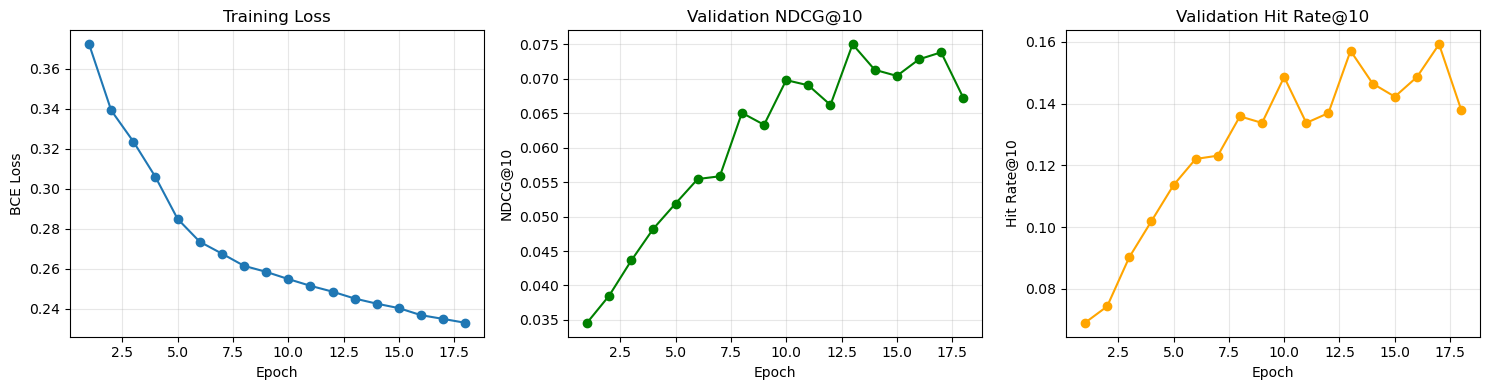

In [51]:
# Plot training history
history_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history_df["epoch"], history_df["loss"], marker="o")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE Loss")
axes[0].set_title("Training Loss")
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_df["epoch"], history_df["NDCG@K"], marker="o", color="green")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("NDCG@10")
axes[1].set_title("Validation NDCG@10")
axes[1].grid(True, alpha=0.3)

axes[2].plot(history_df["epoch"], history_df["HitRate@K"], marker="o", color="orange")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Hit Rate@10")
axes[2].set_title("Validation Hit Rate@10")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Model Comparison

Compare DeepFM with rich features against NeuMF (user_id + item_id only).

In [52]:
# Reference results from NeuMF
neumf_results = {
    5: {"Recall@K": 0.0764, "HitRate@K": 0.0764, "NDCG@K": 0.0486, "MAP@K": 0.0395},
    10: {"Recall@K": 0.1465, "HitRate@K": 0.1465, "NDCG@K": 0.0710, "MAP@K": 0.0486},
    20: {"Recall@K": 0.2367, "HitRate@K": 0.2367, "NDCG@K": 0.0940, "MAP@K": 0.0550},
}

print("Model Comparison (Test Set)")
print("=" * 70)
print("NeuMF: user_id + item_id (2 fields)")
print(f"DeepFM: user_id + age + gender + occupation + item_id + 19 genres ({n_fields} fields)")
print("=" * 70)

for K in [5, 10, 20]:
    print(f"\n@K = {K}:")
    print(f"  {'Metric':<12} {'NeuMF':>10} {'DeepFM':>10} {'Diff':>10} {'% Change':>10}")
    print(f"  {'-'*54}")
    for metric in ["Recall@K", "NDCG@K", "MAP@K"]:
        neumf_val = neumf_results[K][metric]
        deepfm_val = test_metrics[K][metric]
        diff = deepfm_val - neumf_val
        pct_change = (diff / neumf_val * 100) if neumf_val != 0 else 0
        sign = "+" if diff >= 0 else ""
        print(f"  {metric:<12} {neumf_val:>10.4f} {deepfm_val:>10.4f} {sign}{diff:>9.4f} {sign}{pct_change:>9.1f}%")

Model Comparison (Test Set)
NeuMF: user_id + item_id (2 fields)
DeepFM: user_id + age + gender + occupation + item_id + 19 genres (24 fields)

@K = 5:
  Metric            NeuMF     DeepFM       Diff   % Change
  ------------------------------------------------------
  Recall@K         0.0764     0.0870 +   0.0106 +     13.9%
  NDCG@K           0.0486     0.0549 +   0.0063 +     12.9%
  MAP@K            0.0395     0.0444 +   0.0049 +     12.4%

@K = 10:
  Metric            NeuMF     DeepFM       Diff   % Change
  ------------------------------------------------------
  Recall@K         0.1465     0.1592 +   0.0127 +      8.7%
  NDCG@K           0.0710     0.0783 +   0.0073 +     10.3%
  MAP@K            0.0486     0.0542 +   0.0056 +     11.4%

@K = 20:
  Metric            NeuMF     DeepFM       Diff   % Change
  ------------------------------------------------------
  Recall@K         0.2367     0.2420 +   0.0053 +      2.3%
  NDCG@K           0.0940     0.0990 +   0.0050 +      5.3%
 

## 11. Feature Analysis

Let's analyze what the model learned about different feature interactions.

In [28]:
# Analyze embedding norms by feature field
model.eval()
with torch.no_grad():
    # Get all embeddings
    all_embeds = model.fm.embeddings.weight.cpu().numpy()
    
    # Compute field-wise statistics
    field_names = [
        "user_id", "age", "gender", "occupation", "item_id"
    ] + [f"genre_{g}" for g in genre_names]
    
    offsets = [0] + list(np.cumsum(field_dims))
    
    print("Embedding Statistics by Field:")
    print("=" * 60)
    print(f"{'Field':<20} {'Size':>8} {'Mean Norm':>12} {'Std':>10}")
    print("-" * 60)
    
    for i, (name, start, end) in enumerate(zip(field_names, offsets[:-1], offsets[1:])):
        field_embeds = all_embeds[start:end]
        norms = np.linalg.norm(field_embeds, axis=1)
        print(f"{name:<20} {end-start:>8} {np.mean(norms):>12.4f} {np.std(norms):>10.4f}")

Embedding Statistics by Field:
Field                    Size    Mean Norm        Std
------------------------------------------------------------
user_id                   942       0.7101     0.1493
age                         7       0.4647     0.1462
gender                      2       0.3635     0.0729
occupation                 21       0.4405     0.1173
item_id                  1447       0.7556     0.2134
genre_unknown               2       0.1671     0.1252
genre_Action                2       0.3420     0.1632
genre_Adventure             2       0.2616     0.2095
genre_Animation             2       0.4556     0.3402
genre_Children's            2       0.4650     0.3235
genre_Comedy                2       0.2581     0.0916
genre_Crime                 2       0.3225     0.1853
genre_Documentary           2       0.3310     0.2539
genre_Drama                 2       0.2290     0.0886
genre_Fantasy               2       0.2588     0.1067
genre_Film-Noir             2       0.3724  

In [29]:
# Visualize genre importance (by first-order weights)
with torch.no_grad():
    first_order_weights = model.fm.first_order.weight.cpu().numpy().squeeze()
    
    # Extract genre weights (fields 5-23)
    genre_start = sum(field_dims[:5])  # After user_id, age, gender, occupation, item_id
    
    genre_weights = []
    for i, genre in enumerate(genre_names):
        # Each genre field has 2 values (0 and 1)
        field_start = genre_start + i * 2
        # Weight for genre=1 minus weight for genre=0
        weight_diff = first_order_weights[field_start + 1] - first_order_weights[field_start]
        genre_weights.append((genre, weight_diff))
    
    # Sort by weight
    genre_weights.sort(key=lambda x: x[1], reverse=True)
    
    print("\nGenre First-Order Weights (positive = increases prediction):")
    print("=" * 40)
    for genre, weight in genre_weights:
        bar = "+" * int(abs(weight) * 50) if weight > 0 else "-" * int(abs(weight) * 50)
        print(f"{genre:<15} {weight:>8.4f} {bar}")


Genre First-Order Weights (positive = increases prediction):
War               0.1952 +++++++++
Thriller          0.1635 ++++++++
Romance           0.1624 ++++++++
Action            0.1337 ++++++
Mystery           0.1249 ++++++
Sci-Fi            0.1107 +++++
Fantasy           0.1069 +++++
Comedy            0.0988 ++++
Horror            0.0860 ++++
Crime             0.0850 ++++
Drama             0.0651 +++
Adventure         0.0302 +
Western           0.0196 
Musical           0.0194 
Children's       -0.0233 -
Film-Noir        -0.0450 --
unknown          -0.0671 ---
Animation        -0.1180 -----
Documentary      -0.2836 --------------


## 12. Key Takeaways

### Rich Features in DeepFM

This implementation demonstrates DeepFM's full potential by incorporating:

1. **User Features** (4 fields):
   - `user_id`: Captures user-specific preferences
   - `age_bucket`: Age-related preferences (7 buckets)
   - `gender`: Gender-specific tastes
   - `occupation`: Occupation-based patterns

2. **Item Features** (20 fields):
   - `item_id`: Movie-specific characteristics
   - `19 genres`: Content-based signals (Action, Comedy, Drama, etc.)

### Why Rich Features Matter

- **Cold Start**: Genre features help recommend new movies without interaction history
- **Cross-Feature Learning**: FM captures interactions like "young males prefer Action movies"
- **Better Generalization**: User demographics provide signals beyond just interaction patterns

### Architecture Benefits

1. **Shared Embeddings**: Single embedding per feature shared between FM and Deep
2. **Efficient FM**: O(n) pairwise interactions via sum-of-squares trick
3. **Joint Training**: FM and DNN components optimize together

### Comparison with NeuMF

| Aspect | NeuMF | DeepFM (Rich Features) |
|--------|-------|------------------------|
| Feature fields | 2 | 24 |
| User features | ID only | ID + demographics |
| Item features | ID only | ID + genres |
| Cross-features | None | FM captures all pairs |
| Cold start | Poor | Better (content features) |